<a href="https://colab.research.google.com/github/ishikaarora/pytorch-tutorials/blob/master/DefensiveDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random
import time
import math
from tqdm import tqdm

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, transform= transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root= './data',train = False, download = True,
                                      transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size = 1, shuffle = False, num_workers = 2 ) 
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

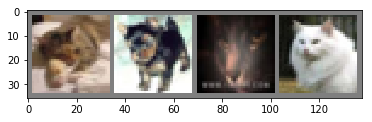

  cat   dog   cat   cat


In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

### CNN Model class

In [0]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

### Loading pretrained model

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda')

In [0]:
model = CNN()
model.load_state_dict(torch.load("cifar10_76"))
model.eval()
model = model.to(device)

In [0]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9
N_EPOCHS = 10

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)

In [0]:
def calculate_accuracy(model,loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    return (correct/total)*100

#### Original model accuracy

In [25]:
test_accuracy = calculate_accuracy(model,testloader)
print(test_accuracy)

KeyboardInterrupt: ignored

### Helper functions

In [0]:
def loss_fn_kd(outputs, labels, teacher_outputs, params):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    alpha = params["alpha"]
    T = params["temperature"]
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [0]:
# Helper function: get [batch_idx, teacher_outputs] list by running teacher model once
def fetch_teacher_outputs(teacher_model, dataloader, params):
    # set teacher_model to evaluation mode
    teacher_model.eval()
    teacher_outputs = []
    for i, (data_batch, labels_batch) in enumerate(dataloader):
        if params["cuda"]:
            data_batch, labels_batch = data_batch.cuda(async=True), \
                                        labels_batch.cuda(async=True)
#         data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)

        output_teacher_batch = teacher_model(data_batch).data.cpu().numpy()
        teacher_outputs.append(output_teacher_batch)

    return teacher_outputs

### Distillation Model functions

In [0]:
# Defining train_kd & train_and_evaluate_kd functions
def train_kd(model, teacher_outputs, optimizer, loss_fn_kd, dataloader, params):
    """Train the model on `num_steps` batches
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn_kd: 
        dataloader: 
        metrics: (dict) 
        params: (Params) hyperparameters
    """

    # set model to training mode
    model.train()
    # teacher_model.eval()

    # summary for current training loop and a running average object for loss
#     summ = []
#     loss_avg = utils.RunningAverage()
    running_loss = 0.0
  
    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params["cuda"]:
                train_batch, labels_batch = train_batch.cuda(async=True), \
                                            labels_batch.cuda(async=True)
            # convert to torch Variables
#             train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output, fetch teacher output, and compute KD loss
            output_batch = model(train_batch)

            # get one batch output from teacher_outputs list
            output_teacher_batch = torch.from_numpy(teacher_outputs[i])
            if params["cuda"]:
                output_teacher_batch = output_teacher_batch.cuda(async=True)
#             output_teacher_batch = Variable(output_teacher_batch, requires_grad=False)

            loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, params)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            # Evaluate summaries only once in a while
#             if i % params.save_summary_steps == 0:
#                 # extract data from torch Variable, move to cpu, convert to numpy arrays
#                 output_batch = output_batch.data.cpu().numpy()
#                 labels_batch = labels_batch.data.cpu().numpy()

#                 # compute all metrics on this batch
#                 summary_batch = {metric:metrics[metric](output_batch, labels_batch)
#                                  for metric in metrics}
#                 summary_batch['loss'] = loss.data[0]
#                 summ.append(summary_batch)

            # update the average loss
#             loss_avg.update(loss.data[0])

#             t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
#             t.update()
            
            running_loss+=loss.item() 
            if i%100==99:
              print(".",end='')


#     # compute mean of all metrics in summary
#     metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
#     metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
#     logging.info("- Train metrics: " + metrics_string)

    return running_loss

 

In [0]:
def train_and_evaluate_kd(model, teacher_model, train_dataloader, val_dataloader, optimizer,
                       loss_fn_kd,restore_file=None):
    """Train the model and evaluate every epoch.
    Args:
        model: (torch.nn.Module) the neural network
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) - file to restore (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
#     if restore_file is not None:
#         restore_path = os.path.join(args.model_dir, args.restore_file + '.pth.tar')
#         logging.info("Restoring parameters from {}".format(restore_path))
#         utils.load_checkpoint(restore_path, model, optimizer)

    best_val_acc = 0.0
    
    # Tensorboard logger setup
    # board_logger = utils.Board_Logger(os.path.join(model_dir, 'board_logs'))

    # fetch teacher outputs using teacher_model under eval() mode
    loading_start = time.time()
    teacher_model.eval()
    teacher_outputs = fetch_teacher_outputs(teacher_model, train_dataloader, params)
    elapsed_time = math.ceil(time.time() - loading_start)
#     logging.info("- Finished computing teacher outputs after {} secs..".format(elapsed_time))

    # learning rate schedulers for different models:
#     if params.model_version == "resnet18_distill":
#         scheduler = StepLR(optimizer, step_size=150, gamma=0.1)
#     # for cnn models, num_epoch is always < 100, so it's intentionally not using scheduler here
#     elif params.model_version == "cnn_distill": 
#         scheduler = StepLR(optimizer, step_size=100, gamma=0.2) 

    for epoch in range(params["num_epochs"]):
#         running_loss = 0.0
        start = time.time()
#         scheduler.step()

        # Run one epoch
#         logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        running_loss = train_kd(model, teacher_outputs, optimizer, loss_fn_kd, train_dataloader, params)

        # Evaluate for one epoch on validation set
#         val_metrics = evaluate_kd(model, val_dataloader, metrics, params)

        train_acc = calculate_accuracy(model,trainloader)      
        val_acc = calculate_accuracy(model,testloader)
        is_best = val_acc>=best_val_acc
      
        time_taken = (time.time()-start)/60
        print("\nIteration: {0} | Time taken: {4} |  Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_acc, val_acc,time_taken))

        # Save weights
#         utils.save_checkpoint({'epoch': epoch + 1,
#                                'state_dict': model.state_dict(),
#                                'optim_dict' : optimizer.state_dict()},
#                                is_best=is_best,
#                                checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
#             logging.info("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
#             best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
#             utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
#         last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
#         utils.save_dict_to_json(val_metrics, last_json_path)


        # #============ TensorBoard logging: uncomment below to turn in on ============#
        # # (1) Log the scalar values
        # info = {
        #     'val accuracy': val_acc
        # }

        # for tag, value in info.items():
        #     board_logger.scalar_summary(tag, value, epoch+1)

        # # (2) Log values and gradients of the parameters (histogram)
        # for tag, value in model.named_parameters():
        #     tag = tag.replace('.', '/')
        #     board_logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
        #     # board_logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)
    return best_val_acc

### Train model with distillation

In [0]:
# model

In [0]:
import copy
teacher_model = copy.deepcopy(model)

In [0]:
new_model = CNN()
new_model = new_model.to(device)

In [0]:
params = {
    "alpha": 0.9,
    "temperature": 20,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "cuda": True
}

#### Params

In [0]:
params = {
#     "model_version": "cnn_distill",
#     "subset_percent": 1.0,
#     "augmentation": "yes",
#     "teacher": "resnet18",
    "alpha": 0.9,
    "temperature": 20,
    "learning_rate": 0.001,
#     "batch_size": 128,
    "num_epochs": 10,
#     "dropout_rate": 0.5, 
#     "num_channels": 32,
#     "save_summary_steps": 100,
#     "num_workers": 4
    "cuda": True
}


In [0]:
# {
#     "model_version": "cnn",
#     "subset_percent": 1.0,
#     "augmentation": "no",
#     "teacher": "none",
#     "alpha": 0,
#     "temperature": 1,
#     "learning_rate": 1e-3,
#     "batch_size": 128,
#     "num_epochs": 30,
#     "dropout_rate": 0.5, 
#     "num_channels": 32,
#     "save_summary_steps": 100,
#     "num_workers": 4
# }

In [44]:
params

{'alpha': 0.9,
 'cuda': True,
 'learning_rate': 0.001,
 'num_epochs': 10,
 'temperature': 20}

### New Model Training

In [62]:
# params = {temperature=20.0, alpha=0.7}
new_model_accuracy = train_and_evaluate_kd(new_model, teacher_model, trainloader, testloader, optimizer, loss_fn_kd,
                              params)

  0%|          | 0/12500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 1 | Time taken: 4.36537564198176 |  Loss: 38358.67885234952 | Training accuracy: 10.126% | Test accuracy: 10.08%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 2 | Time taken: 4.255859382947286 |  Loss: 38359.17667546868 | Training accuracy: 10.108% | Test accuracy: 10.059999999999999%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 3 | Time taken: 4.364721135298411 |  Loss: 38359.22136411071 | Training accuracy: 10.204% | Test accuracy: 10.09%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 4 | Time taken: 4.295168300469716 |  Loss: 38358.70492297411 | Training accuracy: 10.122% | Test accuracy: 10.02%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 5 | Time taken: 4.33351970911026 |  Loss: 38359.19701638818 | Training accuracy: 10.142% | Test accuracy: 10.02%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 6 | Time taken: 4.29356453816096 |  Loss: 38359.15775182843 | Training accuracy: 10.144% | Test accuracy: 10.059999999999999%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 7 | Time taken: 4.343990488847097 |  Loss: 38359.221140027046 | Training accuracy: 10.156% | Test accuracy: 10.08%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 8 | Time taken: 4.244445927937826 |  Loss: 38359.518808960915 | Training accuracy: 10.106% | Test accuracy: 10.02%
.............................................................................................................................


  0%|          | 0/12500 [00:00<?, ?it/s]


Iteration: 9 | Time taken: 4.32000135978063 |  Loss: 38358.9010630548 | Training accuracy: 10.094% | Test accuracy: 10.040000000000001%
.............................................................................................................................


Iteration: 10 | Time taken: 4.3317839940389 |  Loss: 38359.007610052824 | Training accuracy: 10.162% | Test accuracy: 10.100000000000001%


NameError: ignored